In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

In [2]:
#%pip install timm

import timm
import torchvision.models as models

resnet50 = timm.create_model("resnet50", pretrained=True)

import torch.nn as nn

num_classes = 4
model = resnet50
model.fc = nn.Linear(resnet50.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\Admin\Desktop\dl\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda



Training classifier for all items
States: ['Cherry', 'Eggplant', 'Orange', 'Potato']


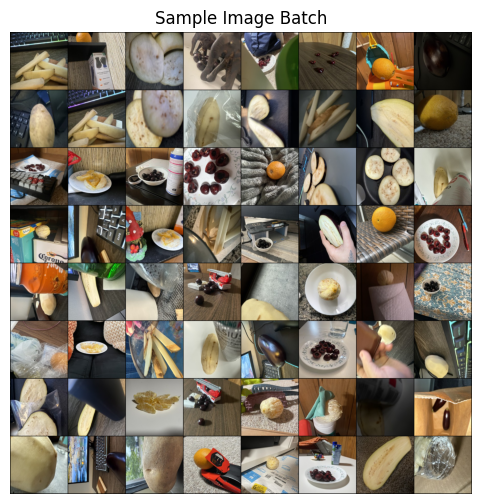

Epoch 1/10 - Train Loss: 0.2658, Acc: 94.62% | Val Loss: 0.0246, Acc: 99.45%
Epoch 2/10 - Train Loss: 0.0170, Acc: 99.68% | Val Loss: 0.0209, Acc: 99.50%
Epoch 3/10 - Train Loss: 0.0188, Acc: 99.65% | Val Loss: 0.0107, Acc: 99.67%
Epoch 4/10 - Train Loss: 0.0119, Acc: 99.65% | Val Loss: 0.0164, Acc: 99.61%
Epoch 5/10 - Train Loss: 0.0024, Acc: 99.94% | Val Loss: 0.0096, Acc: 99.94%
Epoch 6/10 - Train Loss: 0.0100, Acc: 99.78% | Val Loss: 0.0160, Acc: 99.67%
Epoch 7/10 - Train Loss: 0.0132, Acc: 99.74% | Val Loss: 0.0098, Acc: 99.72%
Epoch 8/10 - Train Loss: 0.0196, Acc: 99.75% | Val Loss: 0.0140, Acc: 99.61%
Epoch 9/10 - Train Loss: 0.0080, Acc: 99.76% | Val Loss: 0.0084, Acc: 99.78%
Epoch 10/10 - Train Loss: 0.0012, Acc: 100.00% | Val Loss: 0.0050, Acc: 99.94%

Validation Report for all items.
              precision    recall  f1-score   support

      Cherry     1.0000    1.0000    1.0000       435
    Eggplant     1.0000    1.0000    1.0000       445
      Orange     1.0000    0.99

In [3]:
import os
import torch
import time
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import torchvision
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

data_dir = "Group 2"
output_dir = "models"
plot_dir = "plots"
num_epochs = 10
batch_size = 64
learning_rate = 5e-4
val_split = 0.15
test_split = 0.15
seed = 555

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

os.makedirs(output_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

dataset = ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

print(f"\nTraining classifier for all items")
print(f"States: {class_names}")

total_size = len(dataset)
val_size = int(total_size * val_split)
test_size = int(total_size * test_split)
train_size = total_size - val_size - test_size

torch.manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

images, labels = next(iter(train_loader))

grid_img = torchvision.utils.make_grid(images, nrow=8)

plt.figure(figsize=(6, 6))
plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
plt.title('Sample Image Batch')
plt.axis('off')
plt.show()

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_acc = 0

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.squeeze()).sum().item()

    train_acc = 100 * correct_train / total_train
    train_losses.append(running_loss/100)
    train_accuracies.append(train_acc)
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels.squeeze())
            val_loss += loss.item()

            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels.squeeze()).sum().item()

            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(val_labels.squeeze().cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.2f}%")

print(f"\nValidation Report for all items.")
print(classification_report(all_val_labels, all_val_preds, target_names=class_names, digits=4))

f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
precision = precision_score(all_val_labels, all_val_preds, average='weighted')
recall = recall_score(all_val_labels, all_val_preds, average='weighted')
acc = accuracy_score(all_val_labels, all_val_preds)

print(f"Validation - Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

model_save_path = os.path.join(output_dir, f"all_items_classifier.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names
}, model_save_path)

print(f"Model saved to: {model_save_path}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"All Items - Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title(f"All Items - Accuracy")
plt.legend()

plot_path = os.path.join(plot_dir, f"all_items_metrics.png")
plt.tight_layout()
plt.savefig(plot_path)
plt.close()
print(f"Metrics plot saved to: {plot_path}")

cm = confusion_matrix(all_val_labels, all_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
cm_path = os.path.join(plot_dir, f"all_items_confusion_matrix_val.png")
plt.title(f"All Items - Val Confusion Matrix")
plt.savefig(cm_path)
plt.close()
print(f"Validation confusion matrix saved to: {cm_path}")

model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

print(f"\nTest Report for all items.")
print(classification_report(all_test_labels, all_test_preds, target_names=class_names, digits=4))

f1 = f1_score(all_test_labels, all_test_preds, average='weighted')
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
acc = accuracy_score(all_test_labels, all_test_preds)

print(f"Test - Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

cm = confusion_matrix(all_test_labels, all_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Greens", xticks_rotation=45)
cm_path = os.path.join(plot_dir, f"all_items_confusion_matrix_test.png")
plt.title(f"All Items - Test Confusion Matrix")
plt.savefig(cm_path)
plt.close()
print(f"Test confusion matrix saved to: {cm_path}")


In [4]:
checkpoint = torch.load("models/all_items_classifier.pt")
model.load_state_dict(checkpoint["model_state_dict"])
network = nn.DataParallel(model).to(device)

optimizer = torch.optim.Adam(network.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

network.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = network(images)
        loss = criterion(outputs, labels.squeeze())
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()

test_accuracy = 100 * correct / total
print('Accuracy of the network on the test images: %d %%' % (test_accuracy))
avg_test_loss = test_loss / len(test_loader)

Accuracy of the network on the test images: 99 %


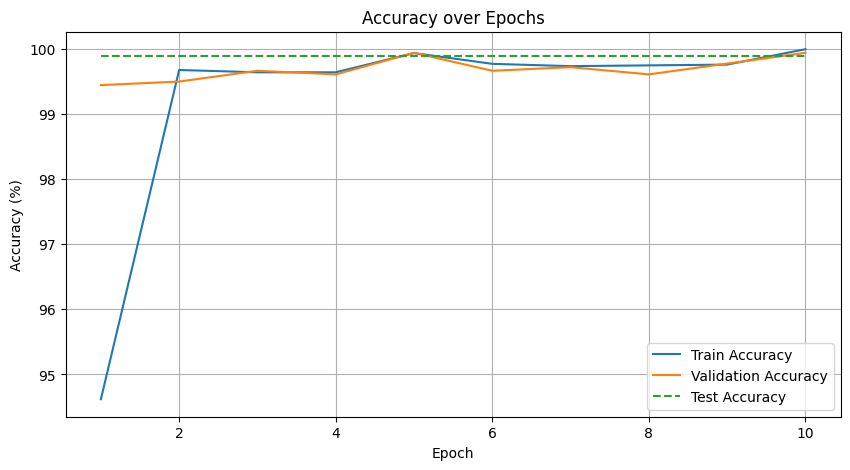

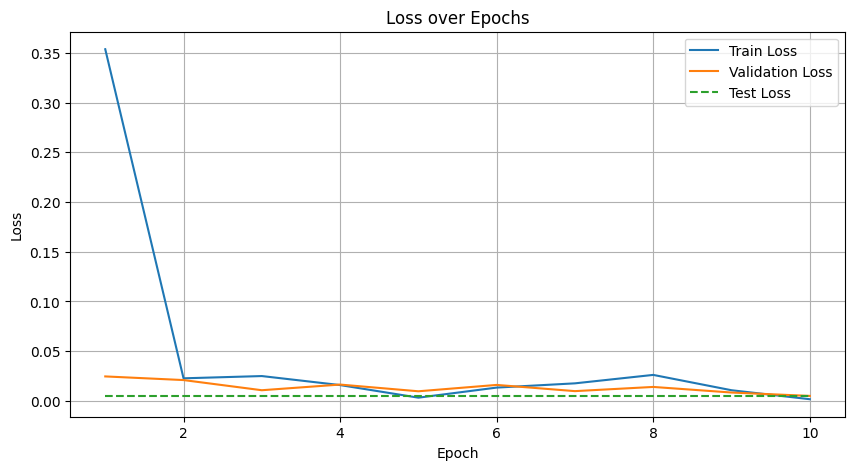

In [5]:
epochs = range(1, len(train_accuracies) + 1)

test_accuracies = [test_accuracy] * len(train_accuracies)
test_losses = [avg_test_loss] * len(train_losses)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

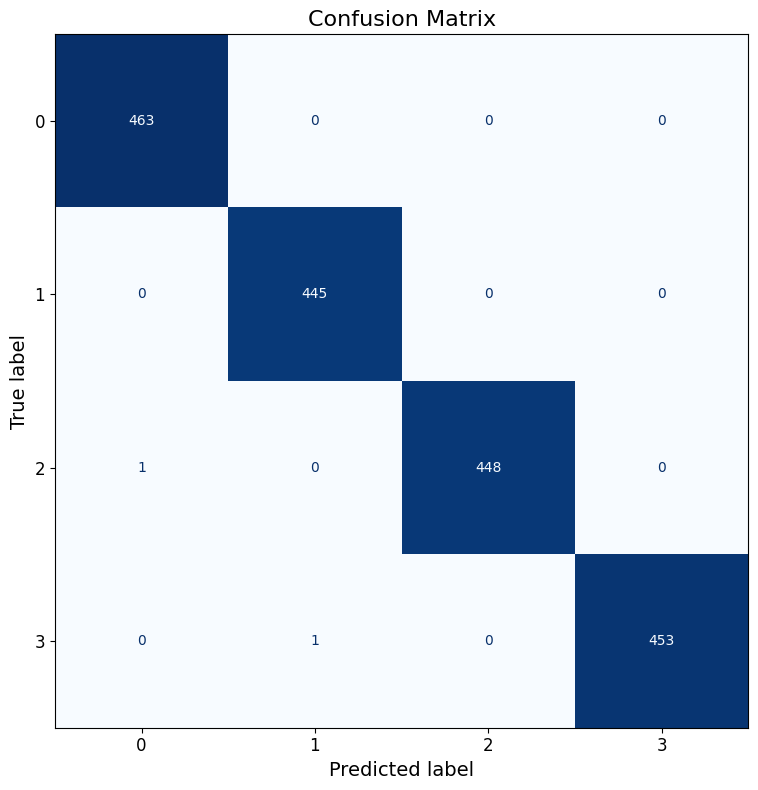

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

network.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = network(inputs)
        probs = torch.softmax(outputs, dim=1)

        all_labels.append(labels)
        all_probs.append(probs)

all_labels = torch.cat(all_labels).cpu()
all_probs = torch.cat(all_probs).cpu()
all_preds = np.argmax(all_probs, axis=1)

cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax, cmap=plt.cm.Blues, colorbar=False)

plt.title("Confusion Matrix", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

precision_avg = np.mean(precision)
recall_avg = np.mean(recall)
f1_avg = np.mean(f1)

print(f"Average Precision: {precision_avg:.4f}")
print(f"Average Recall: {recall_avg:.4f}")
print(f"Average F1 Score: {f1_avg:.4f}")

Precision: [0.99784483 0.99775785 1.         1.        ]
Recall: [1.         1.         0.99777283 0.99779736]
F1 Score: [0.99892125 0.99887767 0.99888517 0.99889746]
Average Precision: 0.9989
Average Recall: 0.9989
Average F1 Score: 0.9989


Total misclassified images: 2


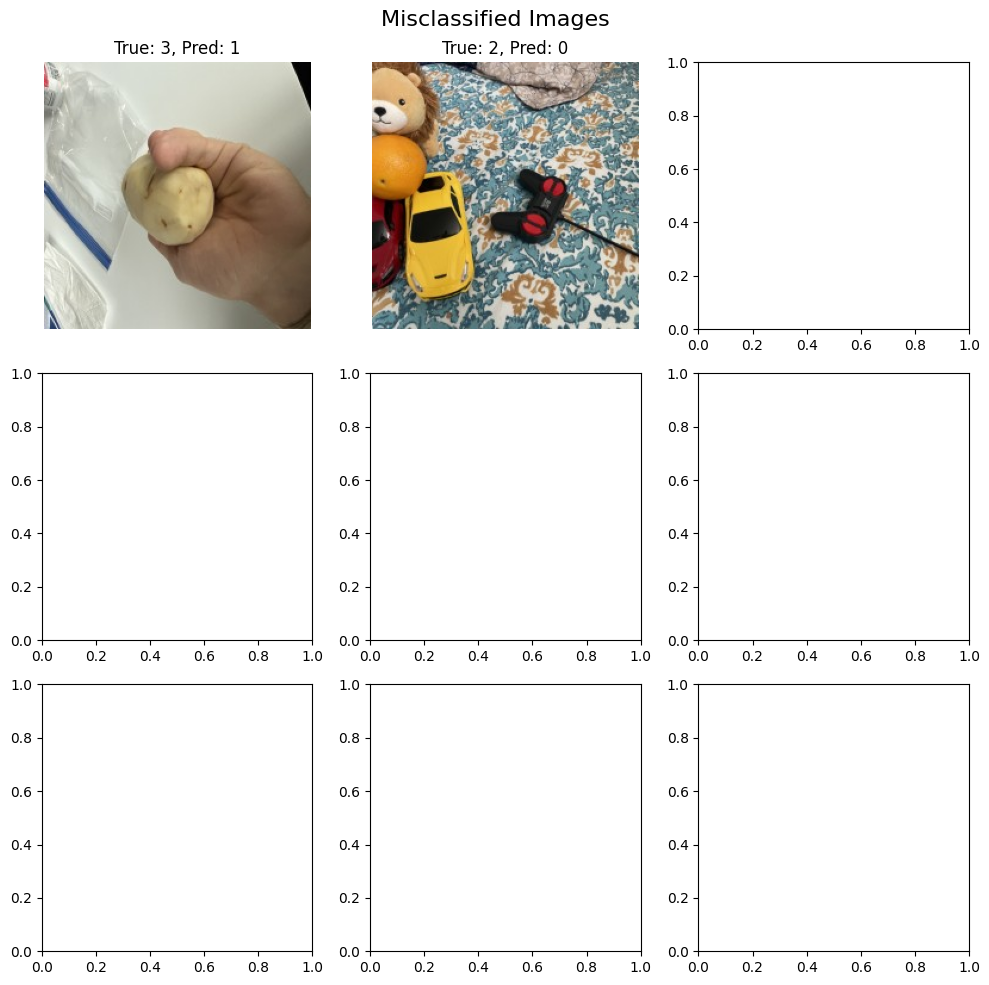

In [8]:
network.eval()

misclassified_images = []
misclassified_preds = []
misclassified_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = network(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        misclassified_mask = preds != labels.squeeze()
        misclassified_images.append(inputs[misclassified_mask].cpu())
        misclassified_preds.append(preds[misclassified_mask].cpu())
        misclassified_labels.append(labels[misclassified_mask].cpu())

misclassified_images = torch.cat(misclassified_images)
misclassified_preds = torch.cat(misclassified_preds)
misclassified_labels = torch.cat(misclassified_labels)

print(f"Total misclassified images: {len(misclassified_images)}")

num_images = min(9, len(misclassified_images))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat[:num_images]):
    img = misclassified_images[i].permute(1, 2, 0).numpy()
    ax.imshow(img.squeeze(), cmap="gray" if img.shape[-1] == 1 else None)
    ax.set_title(f"True: {misclassified_labels[i].item()}, Pred: {misclassified_preds[i].item()}")
    ax.axis('off')

plt.suptitle("Misclassified Images", fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

item_list = ["Eggplant", "Cherry", "Potato", "Orange"]
data_dir = "Group 2"
output_dir = "models"
plot_dir = "plots"
num_epochs = 10
batch_size = 16
learning_rate = 1e-4
val_split = 0.15
test_split = 0.15
seed = 555

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

os.makedirs(output_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

for item_name in item_list:
    item_path = os.path.join(data_dir, item_name)
    dataset = ImageFolder(root=item_path, transform=transform)
    class_names = dataset.classes

    print(f"\nTraining state classifier for: {item_name}")
    print(f"States: {class_names}")

    total_size = len(dataset)
    val_size = int(total_size * val_split)
    test_size = int(total_size * test_split)
    train_size = total_size - val_size - test_size

    torch.manual_seed(seed)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    resnet50 = timm.create_model("resnet50", pretrained=True)
    num_classes = 3
    model = resnet50
    model.fc = nn.Linear(resnet50.fc.in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    best_val_acc = 0

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels.squeeze()).sum().item()

        train_acc = 100 * correct_train / total_train
        train_losses.append(running_loss/100)
        train_accuracies.append(train_acc)
        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels.squeeze())
                val_loss += loss.item()

                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels.squeeze()).sum().item()

                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(val_labels.squeeze().cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.2f}%")

    print(f"\nValidation Report for {item_name}")
    print(classification_report(all_val_labels, all_val_preds, target_names=class_names, digits=4))

    f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    precision = precision_score(all_val_labels, all_val_preds, average='weighted')
    recall = recall_score(all_val_labels, all_val_preds, average='weighted')
    acc = accuracy_score(all_val_labels, all_val_preds)

    print(f"Validation - Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    model_save_path = os.path.join(output_dir, f"{item_name.lower()}_state_classifier.pt")
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names
    }, model_save_path)

    print(f"Model saved to: {model_save_path}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{item_name} - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{item_name} - Accuracy")
    plt.legend()

    plot_path = os.path.join(plot_dir, f"{item_name.lower()}_metrics.png")
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.close()
    print(f"Metrics plot saved to: {plot_path}")

    cm = confusion_matrix(all_val_labels, all_val_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    cm_path = os.path.join(plot_dir, f"{item_name.lower()}_confusion_matrix_val.png")
    plt.title(f"{item_name} - Val Confusion Matrix")
    plt.savefig(cm_path)
    plt.close()
    print(f"Validation confusion matrix saved to: {cm_path}")

    model.eval()
    all_test_preds, all_test_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    print(f"\nTest Report for {item_name}")
    print(classification_report(all_test_labels, all_test_preds, target_names=class_names, digits=4))

    f1 = f1_score(all_test_labels, all_test_preds, average='weighted')
    precision = precision_score(all_test_labels, all_test_preds, average='weighted')
    recall = recall_score(all_test_labels, all_test_preds, average='weighted')
    acc = accuracy_score(all_test_labels, all_test_preds)

    print(f"Test - Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    cm = confusion_matrix(all_test_labels, all_test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Greens", xticks_rotation=45)
    cm_path = os.path.join(plot_dir, f"{item_name.lower()}_confusion_matrix_test.png")
    plt.title(f"{item_name} - Test Confusion Matrix")
    plt.savefig(cm_path)
    plt.close()
    print(f"Test confusion matrix saved to: {cm_path}")



Training state classifier for: Eggplant
States: ['Halved', 'Sliced and Cooked', 'Whole']
Epoch 1/10 - Train Loss: 0.8613, Acc: 79.67% | Val Loss: 0.4043, Acc: 97.35%
Epoch 2/10 - Train Loss: 0.1896, Acc: 97.78% | Val Loss: 0.0516, Acc: 99.34%
Epoch 3/10 - Train Loss: 0.0544, Acc: 99.20% | Val Loss: 0.0211, Acc: 99.56%
Epoch 4/10 - Train Loss: 0.0258, Acc: 99.72% | Val Loss: 0.0140, Acc: 99.56%
Epoch 5/10 - Train Loss: 0.0206, Acc: 99.48% | Val Loss: 0.0145, Acc: 99.34%
Epoch 6/10 - Train Loss: 0.0158, Acc: 99.72% | Val Loss: 0.0090, Acc: 99.56%
Epoch 7/10 - Train Loss: 0.0125, Acc: 99.67% | Val Loss: 0.0135, Acc: 99.34%
Epoch 8/10 - Train Loss: 0.0142, Acc: 99.91% | Val Loss: 0.0081, Acc: 99.56%
Epoch 9/10 - Train Loss: 0.0084, Acc: 99.86% | Val Loss: 0.0077, Acc: 99.56%
Epoch 10/10 - Train Loss: 0.0098, Acc: 99.86% | Val Loss: 0.0069, Acc: 99.56%

Validation Report for Eggplant
                   precision    recall  f1-score   support

           Halved     0.9864    1.0000    0.993